# Markov chain Monte Carlo

In the [maximum likelihood tutorial](./max_likelihood.html), you were introduced to the idea of the **likelihood**, $L$. 
This parameter is just one of the components of Bayes theorem, the foundation of Bayesian inference, 

$$ p = \frac{P L}{Z}, $$ 

where, $p$ is the posterior probability, $P$ is the prior probability, and $Z$ is the evidence (more about these latter two factors in the [custom priors](./custom_priors.html) and [nested sampling](nested_sampling.html) tutorials). 
This tutorial will show how Markov chain Monte Carlo may be used to evaluate the shape of the posterior probability, and show what this means for our understanding of a model's inverse uncertainties. 

Let's start where we left the maximum likelihood tutorial, with a set of variables that maximise the likelihood of some model.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from uravu.relationship import Relationship
from uravu import plotting

In [2]:
np.random.seed(1)

In [3]:
x = np.linspace(0, 10, 20)
y = np.exp(0.5 * x) * 4
y += y * np.random.randn(20) * 0.1
dy = y * 0.2

In [4]:
def my_model(x, a, b):
    """
    A function to describe the model under investgation.
    
    Args:
        x (array_like): Abscissa data.
        a (float): The pre-exponential factor.
        b (float): The x-multiplicative factor.
    
    Returns
        y (array_like): Ordinate data.
    """
    return a * np.exp(b * x)


This time, we have added `bounds` to out `Relationship` object. 
These bounds are are associated with the variables, so in this example the `a` is constrained between $0$ and $10$, while `b` is constrained between $0$ and $1$.

This allows the use of the [differential evoluation](https://en.wikipedia.org/wiki/Differential_evolution) (with the string `'diff_evo'`) minimisation algorithm, which is a global minimisation method.

In [5]:
modeller = Relationship(my_model, x, y, ordinate_error=dy, bounds=((0, 10), (0, 1)))
modeller.max_likelihood('diff_evo')

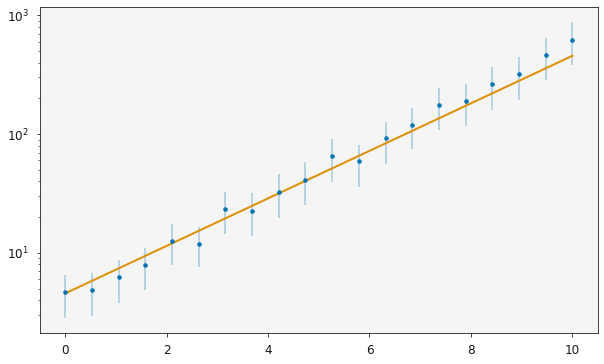

In [6]:
ax = plotting.plot_relationship(modeller)
plt.yscale('log')
plt.show()

The maximum likelihood values for the variables, `a` and `b`, in `my_model()` are,

In [7]:
print(modeller.variable_modes)

[4.55082025 0.46090671]


It is clear from the plot above that there is some uncertainty in the experimental data (shown by the error bars). 
However, there is no uncertainty in the variables currently, because these are the single values which **maximize** the likelihood. 

This is where the posterior distributions are useful. 
If we know the structure of these distributions, we can attribute confidence intervals (and when the distributions are Gaussian, standard deviations) to these variables. 

MCMC is a tool that we can use to *sample* the posterior distribution. 
In `uravu` performing an MCMC sampling for some relationship is as simple as, 

In [8]:
modeller.mcmc()

100%|██████████| 1000/1000 [01:14<00:00, 13.40it/s]


This will run 25000 samples of the posterior distribution. 

Having performed the MCMC sampling, lets visualise the results.

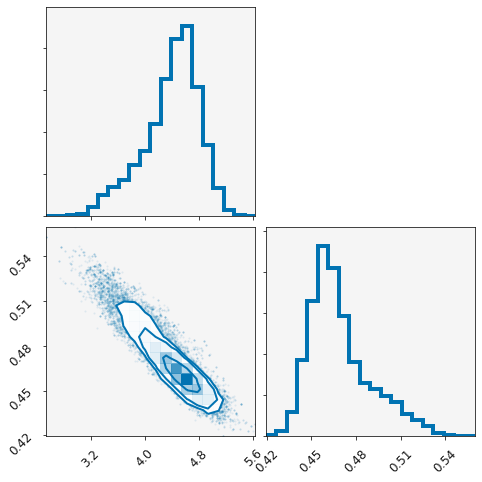

In [9]:
plotting.plot_corner(modeller)
plt.show()

Above is a [corner](https://corner.readthedocs.io/) plot, showing the posterior distribution for each variables and a correlation plot showing the correlation between them. 

We can also print the median or mode of each variable with (these should be slightly different, as the distributions are not normal), 

In [10]:
print(modeller.variable_medians)
print(modeller.variable_modes)

[4.46522622 0.46464549]
[4.56938421 0.45901488]


Each variable is stored in a list in the `variables` object. 

In [11]:
print(modeller.variables[0].samples)

[3.55193264 4.5166827  3.57466299 ... 4.87739729 4.15375473 3.9105342 ]


These objects are of type `uravu.distribution.Distribution`, a special class for storing information about a distribution. 

In [12]:
modeller.variables[0].normal, modeller.variables[0].n, modeller.variables[0].con_int

(False, 4.465226223112712, array([3.40517564, 5.06201216]))

Above we can see that the 0th variable (`a` in the function `my_model`) is not normally distributed and can be reported as $4.46$, with a $95 \%$ confidence interval from $3.43$ to $5.07$. 

The `uravu` plotting will take advantage of these `Distribution` class objects.
When the relationship is plotted, a subset of the models that are probable for the given data will be plotted, giving a *probability distribution* of lines on the plot on top of the data. 

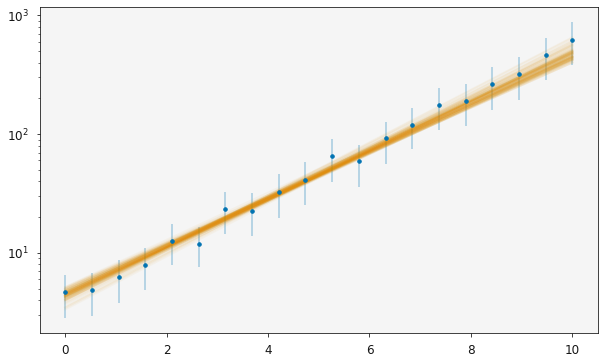

In [13]:
plotting.plot_relationship(modeller)
plt.yscale('log')
plt.show()

The orange line is now spread across most of the measured uncertainties, indicating the range of probable models that are available given the data. 